In [1]:
import sys
sys.path.append("../src")

from models.s4d import S4DModel, S4DConfig, S4DModelForHourlySeries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

df = pd.read_csv("../data/merged_data.csv", parse_dates=["datetime"])
df = df.sort_values("datetime")

df["hour"] = df["datetime"].dt.hour
df["is_daytime"] = ((df["hour"] >= 7) & (df["hour"] < 19)).astype(int)

df = df.drop(columns=["hour"])

df["sin_hour"] = np.sin(2 * np.pi * df["datetime"].dt.hour / 24)
df["cos_hour"] = np.cos(2 * np.pi * df["datetime"].dt.hour / 24)
df["price_lag_1h"] = df["price_EUR_MWh"].shift(1)

df = df.dropna()

# features = [
#     "temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation",
#     "quantity_biomass", "quantity_fossil_gas", "quantity_fossil_hard_coal",
#     "quantity_hydro_run_of_river", "quantity_nuclear", "quantity_solar",
#     "quantity_waste", "quantity_wind_offshore", "quantity_wind_onshore",
#     "quantity_other", "quantity_MW"
# ]
# target = "price_EUR_MWh"

features = [
    "temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation", "quantity_solar",
    "quantity_other", "price_lag_1h", "is_daytime", "sin_hour", "cos_hour", "quantity_MW"
]
target = "price_EUR_MWh"

# Splitting indices before scaling
val_days = 30
val_size = val_days * 24

train_df = df.iloc[:-val_size]
val_df = df.iloc[-val_size:]

# Fit scalers ONLY on training data
scaler_x = StandardScaler()
scaler_y = StandardScaler()

scaler_x.fit(train_df[features])
scaler_y.fit(train_df[[target]])

# Transform entire dataset safely
X = scaler_x.transform(df[features])
y = scaler_y.transform(df[[target]])


In [2]:
class TimeSeriesDataset(Dataset):
    """
    Custom Dataset for time series data with fixed sequence length.
    """
    def __init__(self, X, y, seq_len):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        return (
            self.X[idx:idx+self.seq_len],
            self.y[idx+self.seq_len]
        )

In [3]:
class HourAheadWrapper(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base = base_model   # your S4DModelForHourlySeries

    def forward(self, x, **kwargs):
        seq = self.base(x, mode="convolutional")  # [B, 24]
        return seq[:, -1]

In [18]:
# Splitting the dataset into training and validation sets
# Assuming the data is hourly and we want to validate on the last 30 days
sequence_length = 24
val_days = 30
val_size = val_days * 24

train_X = X[:-val_size]
train_y = y[:-val_size]
val_X = X[-val_size - sequence_length:]

val_y = y[-val_size - sequence_length:]

train_dataset = TimeSeriesDataset(train_X, train_y, sequence_length)
val_dataset = TimeSeriesDataset(val_X, val_y, sequence_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [24]:
# Model Config

config = S4DConfig(    
    state_size   = 32,
    hidden_size  = 16,
    num_layers   = 9,
    dropout      = 0.2,
)

# Model, optimizer, and loss function
n_epochs = 30

model = HourAheadWrapper(S4DModelForHourlySeries(config, in_features=11)).cuda()
optimizer = optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
criterion = nn.L1Loss().cuda()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

# Early stopping parameters

best_val_loss = 1000
patience = 5
patience_counter = 0

# Training the model

model.train()
for epoch in range(n_epochs):
    epoch_loss = 0
    for x, t in train_loader:
        x, t = x.cuda(), t.cuda()
        optimizer.zero_grad()
        preds = model(x, mode="convolutional")
        loss = criterion(preds, t.squeeze(-1))
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, t in val_loader:
            x, t = x.cuda(), t.cuda()
            preds = model(x, mode="convolutional")
            loss = criterion(preds, t.squeeze(-1))
            val_loss += loss.item()
    model.train()

    if val_loss/len(val_loader) < best_val_loss:
        best_val_loss = val_loss/len(val_loader)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

Epoch 1, Train Loss: 0.5351, Val Loss: 0.2556
Epoch 2, Train Loss: 0.3311, Val Loss: 0.2079
Epoch 3, Train Loss: 0.3039, Val Loss: 0.1768
Epoch 4, Train Loss: 0.2761, Val Loss: 0.1753
Epoch 5, Train Loss: 0.2223, Val Loss: 0.1758
Epoch 6, Train Loss: 0.2100, Val Loss: 0.1599
Epoch 7, Train Loss: 0.2012, Val Loss: 0.1565
Epoch 8, Train Loss: 0.1991, Val Loss: 0.1432
Epoch 9, Train Loss: 0.2065, Val Loss: 0.1503
Epoch 10, Train Loss: 0.2062, Val Loss: 0.1533
Epoch 11, Train Loss: 0.1841, Val Loss: 0.1434
Epoch 12, Train Loss: 0.1798, Val Loss: 0.1424
Epoch 13, Train Loss: 0.1758, Val Loss: 0.1467
Epoch 14, Train Loss: 0.1711, Val Loss: 0.1444
Epoch 15, Train Loss: 0.1820, Val Loss: 0.1440
Epoch 16, Train Loss: 0.1912, Val Loss: 0.1469
Epoch 17, Train Loss: 0.1713, Val Loss: 0.1410
Epoch 18, Train Loss: 0.1691, Val Loss: 0.1384
Epoch 19, Train Loss: 0.1674, Val Loss: 0.1453
Epoch 20, Train Loss: 0.1622, Val Loss: 0.1451
Epoch 21, Train Loss: 0.1666, Val Loss: 0.1395
Epoch 22, Train Loss: 

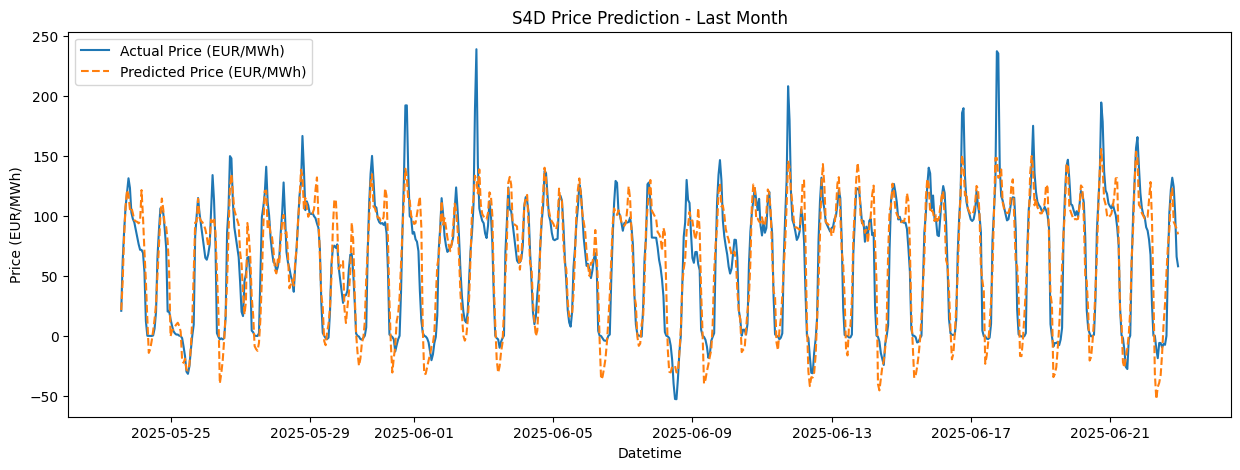

In [25]:
model.eval()
all_preds = []
all_actuals = []
with torch.no_grad():
    for x, t in val_loader:
        x, t = x.cuda(), t.cuda()
        preds = model(x)
        all_preds.append(preds.cpu().numpy())
        all_actuals.append(t.squeeze(-1).cpu().numpy())

preds_flat = np.concatenate(all_preds)
actuals_flat = np.concatenate(all_actuals)

preds_inverse = scaler_y.inverse_transform(preds_flat.reshape(-1, 1)).flatten()
actuals_inverse = scaler_y.inverse_transform(actuals_flat.reshape(-1, 1)).flatten()

# Plotting the results for the last month
val_datetimes = df["datetime"].iloc[-val_size:].reset_index(drop=True)

plt.figure(figsize=(15, 5))
plt.plot(val_datetimes, actuals_inverse, label="Actual Price (EUR/MWh)")
plt.plot(val_datetimes, preds_inverse, label="Predicted Price (EUR/MWh)", linestyle="--")
plt.title("S4D Price Prediction - Last Month")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()

In [26]:
block_size = 6
total_blocks = 28

# Store results per block
block_metrics = []

for i in range(total_blocks):
    start = i * block_size
    end = (i + 1) * block_size

    block_actuals = actuals_inverse[start:end]
    block_preds = preds_inverse[start:end]

    mse = mean_squared_error(block_actuals, block_preds)
    mae = mean_absolute_error(block_actuals, block_preds)

    denom = (np.abs(block_actuals) + np.abs(block_preds)) / 2
    non_zero_mask = denom != 0
    smape = np.mean(np.abs(block_actuals - block_preds)[non_zero_mask] / denom[non_zero_mask]) * 100

    block_metrics.append({
        "Block": i + 1,
        "Start Hour": start,
        "End Hour": end,
        "MSE": mse,
        "MAE": mae,
        "SMAPE": smape
    })

block_df = pd.DataFrame(block_metrics)

# Group into Horizon Tiers
tiers = {
    "Short-term (0-24h)": block_df.iloc[0:4],
    "Medium-term (24-72h)": block_df.iloc[4:12],
    "Long-term (72-168h)": block_df.iloc[12:28]
}

print("\nAggregated Metrics by Horizon Tier:")
for tier_name, tier_df in tiers.items():
    mse_mean = tier_df["MSE"].mean()
    mae_mean = tier_df["MAE"].mean()
    smape_mean = tier_df["SMAPE"].median()
    print(f"\n{tier_name}")
    print(f"MSE: {mse_mean:.2f}")
    print(f"MAE: {mae_mean:.2f}")
    print(f"SMAPE: {smape_mean:.2f}%")


Aggregated Metrics by Horizon Tier:

Short-term (0-24h)
MSE: 306.96
MAE: 13.05
SMAPE: 27.64%

Medium-term (24-72h)
MSE: 374.41
MAE: 13.81
SMAPE: 54.78%

Long-term (72-168h)
MSE: 358.26
MAE: 14.77
SMAPE: 38.52%


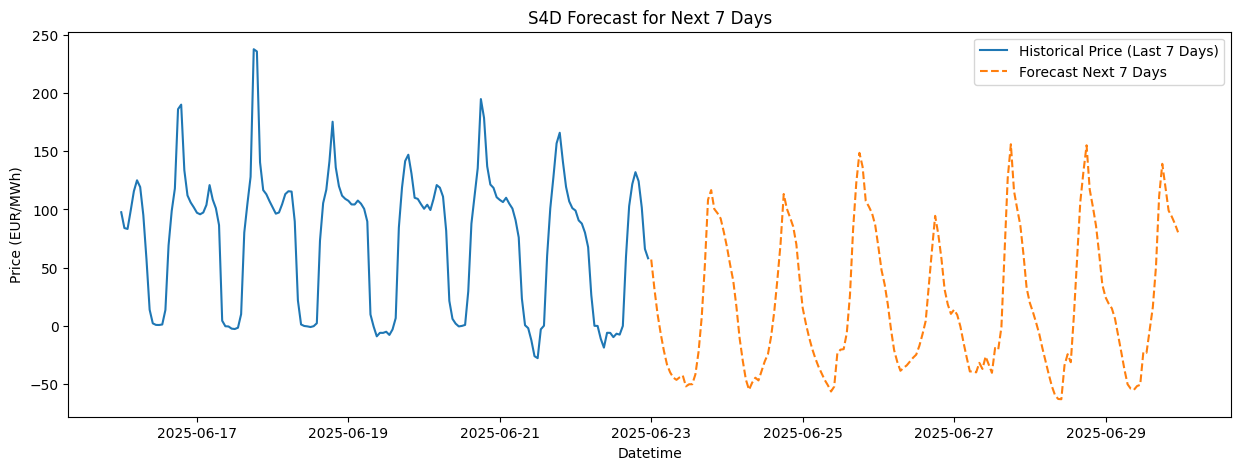

In [27]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

forecast_horizon = 168  # 7 days
# sequence_length = 168

# Load weather forecast
weather_df = pd.read_csv("../data/weather_forecast.csv", parse_dates=["datetime"])
weather_df = weather_df.sort_values("datetime").reset_index(drop=True)

# Optional: Scale weather columns now if your model expects scaled weather inputs
weather_features = ["temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation"]
scaler_weather = StandardScaler()
scaler_weather.fit(df[weather_features])  # Fit only on weather columns
# Scale weather forecast
weather_df[weather_features] = scaler_weather.transform(weather_df[weather_features])

# Prepare latest known features
latest_features = df[features].iloc[-sequence_length:].copy()
latest_scaled = scaler_x.transform(latest_features)

input_seq = torch.tensor(latest_scaled, dtype=torch.float32).unsqueeze(0).cuda()
current_seq = input_seq.clone()

forecast_scaled = []
forecast_unscaled = []

for i in range(forecast_horizon):
    model.eval()
    with torch.no_grad():
        pred_scaled = model(current_seq).item()  # Model predicts scaled price
        forecast_scaled.append(pred_scaled)

    pred_unscaled = scaler_y.inverse_transform(np.array([[pred_scaled]]))[0, 0]
    forecast_unscaled.append(pred_unscaled)

    shifted_seq = current_seq[:, 1:, :].squeeze(0).cpu().numpy()
    next_feature = shifted_seq[-1].copy()

    # Update lag price feature with scaled prediction (model output already scaled)
    idx_lag = features.index('price_lag_1h')
    next_feature[idx_lag] = pred_scaled

    # Generate new datetime
    new_datetime = df["datetime"].iloc[-1] + pd.Timedelta(hours=i + 1)

    # Update time features
    idx_day = features.index('is_daytime')
    next_feature[idx_day] = 1 if 6 <= new_datetime.hour < 20 else 0

    idx_sin = features.index('sin_hour')
    idx_cos = features.index('cos_hour')
    next_feature[idx_sin] = np.sin(2 * np.pi * new_datetime.hour / 24)
    next_feature[idx_cos] = np.cos(2 * np.pi * new_datetime.hour / 24)

    # Inject weather forecast if available
    weather_row = weather_df.loc[weather_df["datetime"] == new_datetime]
    if not weather_row.empty:
        for w_feat in weather_features:
            if w_feat in features:
                idx_w = features.index(w_feat)
                next_feature[idx_w] = weather_row.iloc[0][w_feat]
    else:
        print(f"No weather forecast for {new_datetime}, keeping last known values.")

    # Build new input sequence
    new_seq = np.vstack([shifted_seq, next_feature])
    current_seq = torch.tensor(new_seq, dtype=torch.float32).unsqueeze(0).cuda()

# Create forecast datetimes
forecast_datetimes = pd.date_range(
    start=df["datetime"].iloc[-1] + pd.Timedelta(hours=1),
    periods=forecast_horizon,
    freq="h"
)

# Plot historical + forecast
plt.figure(figsize=(15, 5))
plt.plot(df["datetime"].iloc[-7*24:], df["price_EUR_MWh"].iloc[-7*24:], label="Historical Price (Last 7 Days)")
plt.plot(forecast_datetimes, forecast_unscaled, label="Forecast Next 7 Days", linestyle="--")
plt.title("S4D Forecast for Next 7 Days")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()

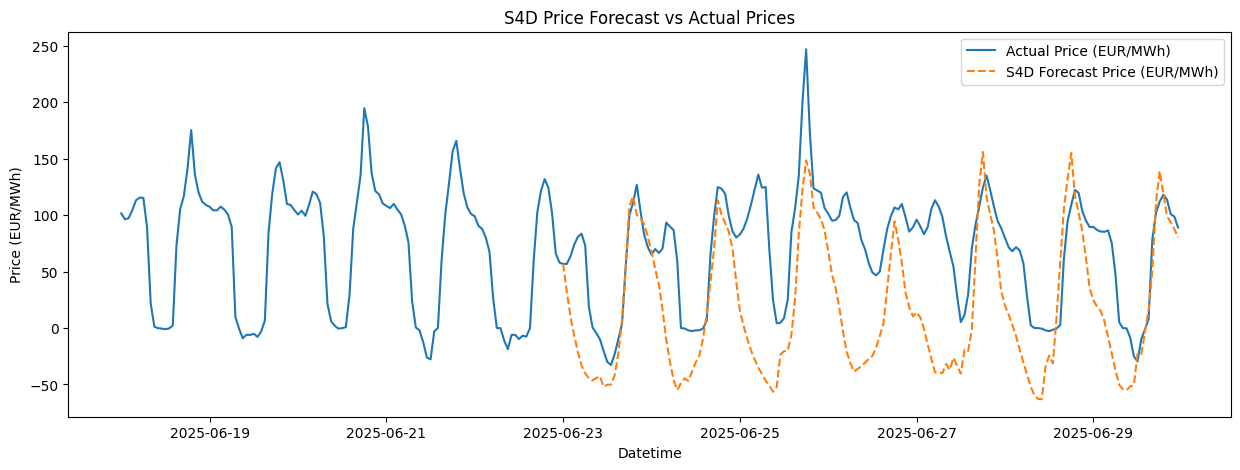

In [28]:
import sys
import pandas as pd
sys.path.append("../src")

from data.fetch_prices import get_energy_prices

df_prices = get_energy_prices("202506180000", "202506300000")

# plot vs predictions
plt.figure(figsize=(15, 5))
plt.plot(df_prices["datetime"], df_prices["price_EUR_MWh"], label="Actual Price (EUR/MWh)")
plt.plot(forecast_datetimes, forecast_unscaled, label="S4D Forecast Price (EUR/MWh)", linestyle="--")
plt.title("S4D Price Forecast vs Actual Prices")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()


# Evaluation


# Number of layers

In [4]:
# ----- Data prep -----
sequence_length = 168
val_days = 7
val_size = val_days * 24

# Train/Val split
train_X = X[:-val_size]
train_y = y[:-val_size]
val_X = X[-val_size - sequence_length:]
val_y = y[-val_size - sequence_length:]

train_dataset = TimeSeriesDataset(train_X, train_y, sequence_length)
val_dataset = TimeSeriesDataset(val_X, val_y, sequence_length)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# ----- Main training & forecasting loop -----
n_epochs = 30
num_layers = [7, 8, 9]
dropout = 0.15
layers_predictions_dict = {}
metrics_dict = {}

for num_layer in num_layers:
    print(f"\n--- Training model with num_layer={num_layer} ---")
    model = HourAheadWrapper(S4DModelForHourlySeries(config=S4DConfig(
        state_size=32,
        hidden_size=16,
        num_layers=num_layer,
        dropout=0.15
    ), in_features=len(features))).cuda()
    optimizer = optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    criterion = nn.L1Loss()

    # Training
    model.train()
    for epoch in range(n_epochs):
        epoch_loss = 0
        for x, t in train_loader:
            x, t = x.cuda(), t.cuda()
            optimizer.zero_grad()
            preds = model(x)
            loss = criterion(preds, t.squeeze(-1))
            loss.backward()
            optimizer.step()
            scheduler.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for x, t in val_loader:
            x, t = x.cuda(), t.cuda()
            preds = model(x)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(t.squeeze(-1).cpu().numpy())

    preds_flat = np.concatenate(all_preds)
    targets_flat = np.concatenate(all_targets)

    preds_inverse = scaler_y.inverse_transform(preds_flat.reshape(-1, 1)).flatten()
    actuals_inverse = scaler_y.inverse_transform(targets_flat.reshape(-1, 1)).flatten()

    layers_predictions_dict[num_layer] = preds_inverse

    # Metrics
    mse = mean_squared_error(actuals_inverse, preds_inverse)
    mae = mean_absolute_error(actuals_inverse, preds_inverse)
    denom = (np.abs(actuals_inverse) + np.abs(preds_inverse)) / 2
    non_zero_mask = denom != 0
    smape = np.mean(np.abs(actuals_inverse - preds_inverse)[non_zero_mask] / denom[non_zero_mask]) * 100

    threshold = np.std(actuals_inverse)
    threshold_accuracy = np.mean(np.abs(actuals_inverse - preds_inverse) < threshold) * 100

    metrics_dict[num_layer] = {
        "MSE": round(mse, 2),
        "MAE": round(mae, 2),
        "SMAPE": round(smape, 2),
        "Threshold Accuracy": round(threshold_accuracy, 2)
    }


--- Training model with num_layer=7 ---
Epoch 1/30, Loss: 0.6034
Epoch 2/30, Loss: 0.3831
Epoch 3/30, Loss: 0.3440
Epoch 4/30, Loss: 0.2768
Epoch 5/30, Loss: 0.2764
Epoch 6/30, Loss: 0.2323
Epoch 7/30, Loss: 0.2171
Epoch 8/30, Loss: 0.1959
Epoch 9/30, Loss: 0.1872
Epoch 10/30, Loss: 0.1999
Epoch 11/30, Loss: 0.1905
Epoch 12/30, Loss: 0.1739
Epoch 13/30, Loss: 0.2017
Epoch 14/30, Loss: 0.1834
Epoch 15/30, Loss: 0.1793
Epoch 16/30, Loss: 0.1728
Epoch 17/30, Loss: 0.1633
Epoch 18/30, Loss: 0.1938
Epoch 19/30, Loss: 0.1739
Epoch 20/30, Loss: 0.1628
Epoch 21/30, Loss: 0.1679
Epoch 22/30, Loss: 0.1643
Epoch 23/30, Loss: 0.1747
Epoch 24/30, Loss: 0.1676
Epoch 25/30, Loss: 0.1576
Epoch 26/30, Loss: 0.1781
Epoch 27/30, Loss: 0.1629
Epoch 28/30, Loss: 0.1570
Epoch 29/30, Loss: 0.1583
Epoch 30/30, Loss: 0.1509

--- Training model with num_layer=8 ---
Epoch 1/30, Loss: 0.7248
Epoch 2/30, Loss: 0.3746
Epoch 3/30, Loss: 0.3389
Epoch 4/30, Loss: 0.3394
Epoch 5/30, Loss: 0.2880
Epoch 6/30, Loss: 0.23

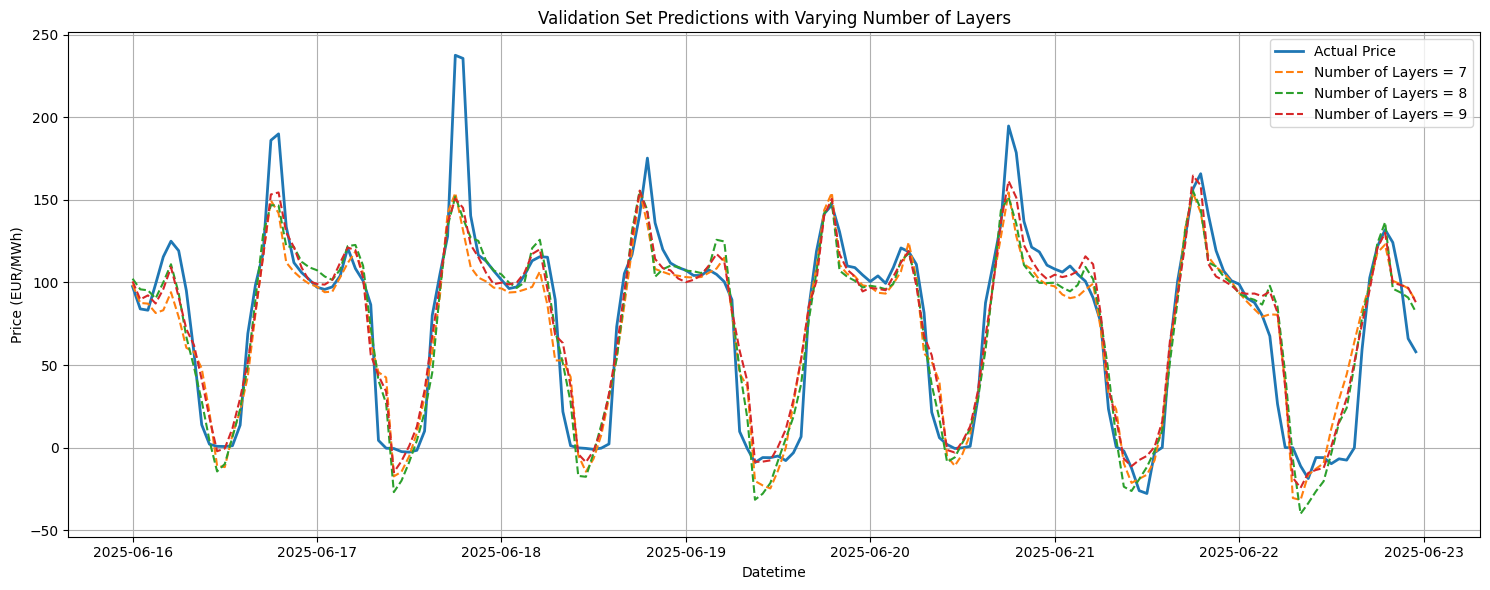

In [5]:
# Plot predictions for each num_layer on validation set
val_datetimes = df["datetime"].iloc[-val_size:].reset_index(drop=True)

plt.figure(figsize=(15, 6))
plt.plot(val_datetimes, df["price_EUR_MWh"].iloc[-val_size:], label="Actual Price", linewidth=2)

for num_layer, preds in layers_predictions_dict.items():
    plt.plot(val_datetimes, preds, label=f"Number of Layers = {num_layer}", linestyle="--")

plt.title("Validation Set Predictions with Varying Number of Layers")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
print("\n=== Validation Metrics per Number of Layers ===")
for num_layer, metrics in metrics_dict.items():
    print(f"\nNumber of Layers = {num_layer}")
    print(f"  MSE   : {metrics['MSE']}")
    print(f"  MAE   : {metrics['MAE']}")
    print(f"  SMAPE : {metrics['SMAPE']}%")
    print(f"  Threshold Accuracy: {metrics['Threshold Accuracy']}%")


=== Validation Metrics per Number of Layers ===

Number of Layers = 7
  MSE   : 512.82
  MAE   : 16.18
  SMAPE : 54.54999923706055%
  Threshold Accuracy: 98.21%

Number of Layers = 8
  MSE   : 412.35
  MAE   : 14.71
  SMAPE : 53.08000183105469%
  Threshold Accuracy: 98.21%

Number of Layers = 9
  MSE   : 397.96
  MAE   : 13.76
  SMAPE : 53.619998931884766%
  Threshold Accuracy: 98.81%


# Dropout


In [7]:
# ----- Data prep -----
sequence_length = 168
val_days = 7
val_size = val_days * 24

# Train/Val split
train_X = X[:-val_size]
train_y = y[:-val_size]
val_X = X[-val_size - sequence_length:]
val_y = y[-val_size - sequence_length:]

train_dataset = TimeSeriesDataset(train_X, train_y, sequence_length)
val_dataset = TimeSeriesDataset(val_X, val_y, sequence_length)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# ----- Main training & forecasting loop -----
n_epochs = 30
num_layers = 8
dropouts = [0.1, 0.15, 0.2]
dropout_predictions_dict = {}
metrics_dict = {}

for dropout in dropouts:
    print(f"\n--- Training model with dropout={dropout} ---")
    model = HourAheadWrapper(S4DModelForHourlySeries(config=S4DConfig(
        state_size=32,
        hidden_size=16,
        num_layers=8,
        dropout=dropout
    ), in_features=len(features))).cuda()
    optimizer = optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    criterion = nn.L1Loss()

    # Training
    model.train()
    for epoch in range(n_epochs):
        epoch_loss = 0
        for x, t in train_loader:
            x, t = x.cuda(), t.cuda()
            optimizer.zero_grad()
            preds = model(x)
            loss = criterion(preds, t.squeeze(-1))
            loss.backward()
            optimizer.step()
            scheduler.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for x, t in val_loader:
            x, t = x.cuda(), t.cuda()
            preds = model(x)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(t.squeeze(-1).cpu().numpy())

    preds_flat = np.concatenate(all_preds)
    targets_flat = np.concatenate(all_targets)

    preds_inverse = scaler_y.inverse_transform(preds_flat.reshape(-1, 1)).flatten()
    targets_inverse = scaler_y.inverse_transform(targets_flat.reshape(-1, 1)).flatten()

    dropout_predictions_dict[dropout] = preds_inverse

    # Metrics
    mse = mean_squared_error(targets_inverse, preds_inverse)
    mae = mean_absolute_error(targets_inverse, preds_inverse)
    denom = (np.abs(targets_inverse) + np.abs(preds_inverse)) / 2
    non_zero_mask = denom != 0
    smape = np.mean(np.abs(targets_inverse - preds_inverse)[non_zero_mask] / denom[non_zero_mask]) * 100

    threshold = np.std(targets_inverse)
    threshold_accuracy = np.mean(np.abs(targets_inverse - preds_inverse) < threshold) * 100

    metrics_dict[dropout] = {
        "MSE": round(mse, 2),
        "MAE": round(mae, 2),
        "SMAPE": round(smape, 2),
        "Threshold Accuracy": round(threshold_accuracy, 2)
    }


--- Training model with dropout=0.1 ---
Epoch 1/30, Loss: 0.6895
Epoch 2/30, Loss: 0.3980
Epoch 3/30, Loss: 0.3244
Epoch 4/30, Loss: 0.2618
Epoch 5/30, Loss: 0.2553
Epoch 6/30, Loss: 0.2290
Epoch 7/30, Loss: 0.2148
Epoch 8/30, Loss: 0.2004
Epoch 9/30, Loss: 0.1897
Epoch 10/30, Loss: 0.1939
Epoch 11/30, Loss: 0.1880
Epoch 12/30, Loss: 0.1785
Epoch 13/30, Loss: 0.1997
Epoch 14/30, Loss: 0.1840
Epoch 15/30, Loss: 0.1766
Epoch 16/30, Loss: 0.1752
Epoch 17/30, Loss: 0.1660
Epoch 18/30, Loss: 0.1954
Epoch 19/30, Loss: 0.1723
Epoch 20/30, Loss: 0.1630
Epoch 21/30, Loss: 0.1640
Epoch 22/30, Loss: 0.1584
Epoch 23/30, Loss: 0.1656
Epoch 24/30, Loss: 0.1630
Epoch 25/30, Loss: 0.1532
Epoch 26/30, Loss: 0.1752
Epoch 27/30, Loss: 0.1612
Epoch 28/30, Loss: 0.1524
Epoch 29/30, Loss: 0.1550
Epoch 30/30, Loss: 0.1496

--- Training model with dropout=0.15 ---
Epoch 1/30, Loss: 0.6077
Epoch 2/30, Loss: 0.3899
Epoch 3/30, Loss: 0.3366
Epoch 4/30, Loss: 0.3174
Epoch 5/30, Loss: 0.2904
Epoch 6/30, Loss: 0.2

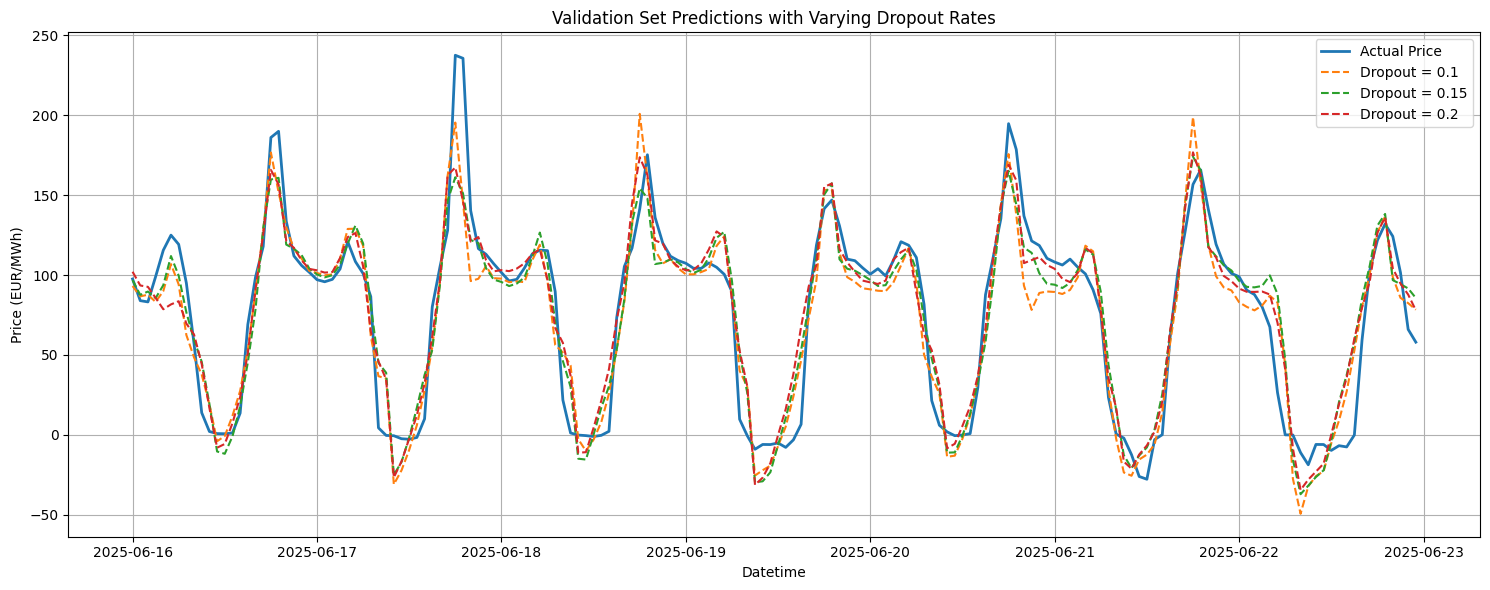

In [8]:
# Plot predictions for each dropout on validation set
val_datetimes = df["datetime"].iloc[-val_size:].reset_index(drop=True)

plt.figure(figsize=(15, 6))
plt.plot(val_datetimes, df["price_EUR_MWh"].iloc[-val_size:], label="Actual Price", linewidth=2)

for dropout, preds in dropout_predictions_dict.items():
    plt.plot(val_datetimes, preds, label=f"Dropout = {dropout}", linestyle="--")

plt.title("Validation Set Predictions with Varying Dropout Rates")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
print("\n=== Validation Metrics per Dropout Rate ===")
for dropout, metrics in metrics_dict.items():
    print(f"\nDropout = {dropout}")
    print(f"  MSE   : {metrics['MSE']}")
    print(f"  MAE   : {metrics['MAE']}")
    print(f"  SMAPE : {metrics['SMAPE']}%")
    print(f"  Threshold Accuracy: {metrics['Threshold Accuracy']}%")


=== Validation Metrics per Dropout Rate ===

Dropout = 0.1
  MSE   : 459.46
  MAE   : 16.72
  SMAPE : 55.779998779296875%
  Threshold Accuracy: 98.81%

Dropout = 0.15
  MSE   : 429.22
  MAE   : 15.65
  SMAPE : 55.59000015258789%
  Threshold Accuracy: 98.21%

Dropout = 0.2
  MSE   : 435.02
  MAE   : 15.42
  SMAPE : 56.619998931884766%
  Threshold Accuracy: 97.62%


# Sequence Length


In [10]:
sequence_lengths = [24, 72, 168]
val_days = 7
val_size = val_days * 24

n_epochs = 30
seq_predictions_dict = {}
metrics_dict = {}

# For consistent validation targets
val_targets = y[-val_size:]
val_targets_inverse = scaler_y.inverse_transform(val_targets.reshape(-1, 1)).flatten()

for seq_len in sequence_lengths:
    print(f"\n--- Training model with sequence_length={seq_len} ---")

    # Prepare train/val split for this sequence length
    train_X = X[:-val_size]
    train_y = y[:-val_size]
    val_X = X[-val_size - seq_len:]
    val_y = y[-val_size - seq_len:]

    train_dataset = TimeSeriesDataset(train_X, train_y, seq_len)
    val_dataset = TimeSeriesDataset(val_X, val_y, seq_len)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize model
    model = HourAheadWrapper(S4DModelForHourlySeries(config=S4DConfig(
        state_size=32,
        hidden_size=16,
        num_layers=8,
        dropout=0.15
    ), in_features=len(features))).cuda()
    optimizer = optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    criterion = nn.L1Loss()

    # Training loop
    model.train()
    for epoch in range(n_epochs):
        epoch_loss = 0
        for x, t in train_loader:
            x, t = x.cuda(), t.cuda()
            optimizer.zero_grad()
            preds = model(x)
            loss = criterion(preds, t.squeeze(-1))
            loss.backward()
            optimizer.step()
            scheduler.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

    # Validation prediction
    model.eval()
    all_preds = []
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.cuda()
            preds = model(x)
            all_preds.append(preds.cpu().numpy())

    preds_flat = np.concatenate(all_preds)
    preds_inverse = scaler_y.inverse_transform(preds_flat.reshape(-1, 1)).flatten()

    # Align predictions to last val_size points
    aligned_preds = preds_inverse[-val_size:]
    seq_predictions_dict[seq_len] = aligned_preds

    # Metrics
    mse = mean_squared_error(val_targets_inverse, aligned_preds)
    mae = mean_absolute_error(val_targets_inverse, aligned_preds)
    denom = (np.abs(val_targets_inverse) + np.abs(aligned_preds)) / 2
    non_zero_mask = denom != 0
    smape = np.mean(np.abs(val_targets_inverse - aligned_preds)[non_zero_mask] / denom[non_zero_mask]) * 100

    threshold = np.std(actuals_inverse)
    threshold_accuracy = np.mean(np.abs(targets_inverse - preds_inverse) < threshold) * 100

    metrics_dict[seq_len] = {
        "MSE": round(mse, 2),
        "MAE": round(mae, 2),
        "SMAPE": round(smape, 2),
        "Threshold Accuracy": round(threshold_accuracy, 2)
    }


--- Training model with sequence_length=24 ---
Epoch 1/30, Loss: 0.5960
Epoch 2/30, Loss: 0.3390
Epoch 3/30, Loss: 0.2822
Epoch 4/30, Loss: 0.2598
Epoch 5/30, Loss: 0.2191
Epoch 6/30, Loss: 0.2152
Epoch 7/30, Loss: 0.1938
Epoch 8/30, Loss: 0.1909
Epoch 9/30, Loss: 0.1815
Epoch 10/30, Loss: 0.1799
Epoch 11/30, Loss: 0.1760
Epoch 12/30, Loss: 0.1714
Epoch 13/30, Loss: 0.1746
Epoch 14/30, Loss: 0.1643
Epoch 15/30, Loss: 0.1820
Epoch 16/30, Loss: 0.1676
Epoch 17/30, Loss: 0.1825
Epoch 18/30, Loss: 0.1701
Epoch 19/30, Loss: 0.1704
Epoch 20/30, Loss: 0.1671
Epoch 21/30, Loss: 0.1629
Epoch 22/30, Loss: 0.1630
Epoch 23/30, Loss: 0.1577
Epoch 24/30, Loss: 0.1588
Epoch 25/30, Loss: 0.1565
Epoch 26/30, Loss: 0.1580
Epoch 27/30, Loss: 0.1551
Epoch 28/30, Loss: 0.1561
Epoch 29/30, Loss: 0.1520
Epoch 30/30, Loss: 0.1631

--- Training model with sequence_length=72 ---
Epoch 1/30, Loss: 0.7461
Epoch 2/30, Loss: 0.4432
Epoch 3/30, Loss: 0.3506
Epoch 4/30, Loss: 0.3429
Epoch 5/30, Loss: 0.2772
Epoch 6/

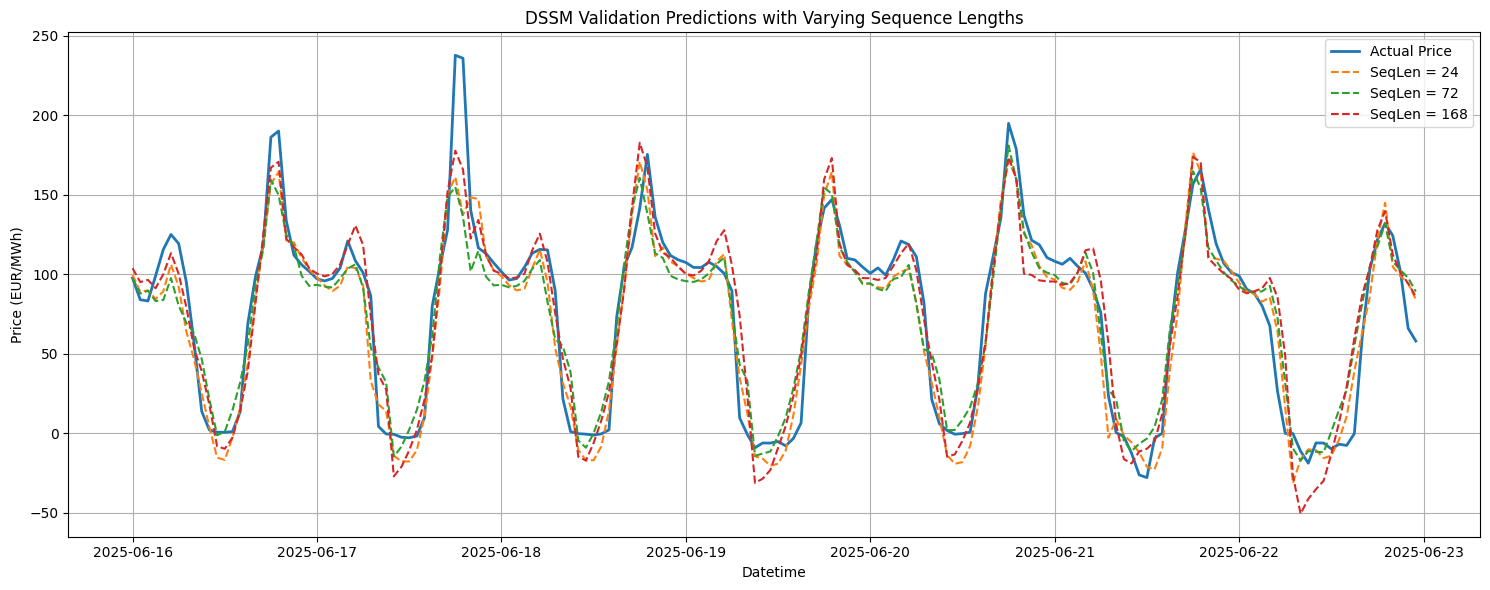

In [11]:
val_datetimes = df["datetime"].iloc[-val_size:].reset_index(drop=True)

plt.figure(figsize=(15, 6))
plt.plot(val_datetimes, val_targets_inverse, label="Actual Price", linewidth=2)

for seq_len, preds in seq_predictions_dict.items():
    plt.plot(val_datetimes, preds, label=f"SeqLen = {seq_len}", linestyle="--")

plt.title("DSSM Validation Predictions with Varying Sequence Lengths")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
print("\n=== Validation Metrics by Sequence Length ===")
for seq_len, metrics in metrics_dict.items():
    print(f"\nSequence Length = {seq_len}")
    print(f"  MSE   : {metrics['MSE']}")
    print(f"  MAE   : {metrics['MAE']}")
    print(f"  SMAPE : {metrics['SMAPE']}%")
    print(f"  Threshold Accuracy: {metrics['Threshold Accuracy']}%")


=== Validation Metrics by Sequence Length ===

Sequence Length = 24
  MSE   : 356.33
  MAE   : 14.05
  SMAPE : 51.22%
  Threshold Accuracy: 98.81%

Sequence Length = 72
  MSE   : 431.47
  MAE   : 15.16
  SMAPE : 54.2%
  Threshold Accuracy: 98.81%

Sequence Length = 168
  MSE   : 400.22
  MAE   : 15.09
  SMAPE : 54.63%
  Threshold Accuracy: 97.02%
